<a href="https://colab.research.google.com/github/moumahan1990/retail_timeseries_forecasting/blob/master/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 83.1MB 47kB/s 
     |████████████████████████████████| 3.1MB 34.2MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


2.2.0-rc2


In [0]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,RNN, SimpleRNN 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
# additional store data
store = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/store.csv",low_memory = False)

In [147]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [148]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [149]:
# Creating new features from date 
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [150]:
# Filtering out stores which are closed and has zero sales
train_data = train[train.Store == 1]
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]
train_data=train_data.sort_index()
train_data=train_data.fillna(0)
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
train_data_X = train_data[['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'SalePerCustomer']]

In [0]:
train_data_y = train_data[['Sales']]

In [153]:
#Creating train test split
# X_train = train_data_X.head(730)
# X_test = train_data_X.tail(50)
# y_train = train_data_y.head(730)
# y_test = train_data_y.tail(50)

number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(train_data) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(train_data), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 781 681 50 50


In [154]:
datatrain = train_data[:number_of_training_data]
datatest = train_data[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = train_data[-number_of_holdout_data:]
datatrain.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
#Preparing Train,Test,Validation data for TimeSeriesGenerator
in_seq1 = array(datatrain['Month'])
in_seq2 = array(datatrain['Day'])
in_seq3 = array(datatrain['WeekOfYear'])
in_seq4 = array(datatrain['DayOfWeek'])
in_seq5 = array(datatrain['Open'])
in_seq6 = array(datatrain['Promo'])
in_seq7 = array(datatrain['StateHoliday'])
in_seq8 = array(datatrain['SchoolHoliday'])
in_seq9 = array(datatrain['SalePerCustomer'])

out_seq_train = array(datatrain['Sales'])

In [0]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))


In [157]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_train))
datatrain_feed

array([[1, 2, 1, ..., 1, 8.278443113772456, 5530],
       [1, 3, 1, ..., 1, 7.486159169550173, 4327],
       [1, 4, 1, ..., 1, 7.247172859450727, 4486],
       ...,
       [3, 27, 13, ..., 0, 7.570888468809073, 4005],
       [3, 28, 13, ..., 0, 8.608264462809917, 5208],
       [3, 30, 14, ..., 1, 9.63271162123386, 6714]], dtype=object)

In [0]:
in_seq1 = array(datahold['Month'])
in_seq2 = array(datahold['Day'])
in_seq3 = array(datahold['WeekOfYear'])
in_seq4 = array(datahold['DayOfWeek'])
in_seq5 = array(datahold['Open'])
in_seq6 = array(datahold['Promo'])
in_seq7 = array(datahold['StateHoliday'])
in_seq8 = array(datahold['SchoolHoliday'])
in_seq9 = array(datahold['SalePerCustomer'])

out_seq_hold = array(datahold['Sales'])

In [159]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))
out_seq_hold.shape

(50, 1)

In [160]:
datathold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_hold))
datathold_feed

array([[6, 3, 23, 3, 1, 1, '0', 0, 9.430194805194805, 5809],
       [6, 5, 23, 5, 1, 1, '0', 0, 8.84072249589491, 5384],
       [6, 6, 23, 6, 1, 0, '0', 0, 9.093478260869565, 4183],
       [6, 8, 24, 1, 1, 0, '0', 0, 8.109561752988048, 4071],
       [6, 9, 24, 2, 1, 0, '0', 0, 8.457731958762887, 4102],
       [6, 10, 24, 3, 1, 0, '0', 0, 7.927152317880795, 3591],
       [6, 11, 24, 4, 1, 0, '0', 0, 8.205882352941176, 3627],
       [6, 12, 24, 5, 1, 0, '0', 0, 8.755924170616113, 3695],
       [6, 13, 24, 6, 1, 0, '0', 0, 8.47808764940239, 4256],
       [6, 15, 25, 1, 1, 1, '0', 0, 9.416382252559726, 5518],
       [6, 16, 25, 2, 1, 1, '0', 0, 9.646123260437376, 4852],
       [6, 17, 25, 3, 1, 1, '0', 0, 8.403361344537815, 4000],
       [6, 18, 25, 4, 1, 1, '0', 0, 9.32730923694779, 4645],
       [6, 19, 25, 5, 1, 1, '0', 0, 8.628336755646817, 4202],
       [6, 20, 25, 6, 1, 0, '0', 0, 8.293522267206479, 4097],
       [6, 22, 26, 1, 1, 0, '0', 0, 7.865030674846626, 3846],
       [6, 23, 2

In [0]:
in_seq1 = array(datatest['Month'])
in_seq2 = array(datatest['Day'])
in_seq3 = array(datatest['WeekOfYear'])
in_seq4 = array(datatest['DayOfWeek'])
in_seq5 = array(datatest['Open'])
in_seq6 = array(datatest['Promo'])
in_seq7 = array(datatest['StateHoliday'])
in_seq8 = array(datatest['SchoolHoliday'])
in_seq9 = array(datatest['SalePerCustomer'])

out_seq_test = array(datatest['Sales'])

In [162]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_test = out_seq_hold.reshape((len(out_seq_test), 1))
out_seq_test.shape

(50, 1)

In [163]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_test))
datatest_feed.shape

(50, 10)

In [0]:
# TimeSeries Generator for Train data 
n_features = datatrain_feed.shape[1]
n_input = 1
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=1)


In [165]:
for i in range(len(generator_train)):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

[[[1 2 1 3 1 0 '0' 1 8.278443113772456 5530]]] => [[4327]]
[[[1 3 1 4 1 0 '0' 1 7.486159169550173 4327]]] => [[4486]]
[[[1 4 1 5 1 0 '0' 1 7.247172859450727 4486]]] => [[4997]]
[[[1 5 1 6 1 0 '0' 1 7.869291338582677 4997]]] => [[7176]]
[[[1 7 2 1 1 1 '0' 1 9.14140127388535 7176]]] => [[5580]]
[[[1 8 2 2 1 1 '0' 1 8.53211009174312 5580]]] => [[5471]]
[[[1 9 2 3 1 1 '0' 1 8.73961661341853 5471]]] => [[4892]]
[[[1 10 2 4 1 1 '0' 1 7.954471544715447 4892]]] => [[4881]]
[[[1 11 2 5 1 1 '0' 1 8.244932432432432 4881]]] => [[4952]]
[[[1 12 2 6 1 0 '0' 0 7.6656346749226 4952]]] => [[4717]]
[[[1 14 3 1 1 0 '0' 0 7.657467532467533 4717]]] => [[3900]]
[[[1 15 3 2 1 0 '0' 0 7.6171875 3900]]] => [[4008]]
[[[1 16 3 3 1 0 '0' 0 7.562264150943396 4008]]] => [[4044]]
[[[1 17 3 4 1 0 '0' 0 8.03976143141153 4044]]] => [[4127]]
[[[1 18 3 5 1 0 '0' 0 7.265845070422535 4127]]] => [[5182]]
[[[1 19 3 6 1 0 '0' 0 7.531976744186046 5182]]] => [[5394]]
[[[1 21 4 1 1 1 '0' 0 8.886326194398682 5394]]] => [[5720]]
[

In [0]:
# TimeSeries Generator for Val data
generator_hold = TimeseriesGenerator(datathold_feed, out_seq_hold, length=1, batch_size=1)

In [167]:
for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    print('%s => %s' % (x, y))

[[[6 3 23 3 1 1 '0' 0 9.430194805194805 5809]]] => [[5384]]
[[[6 5 23 5 1 1 '0' 0 8.84072249589491 5384]]] => [[4183]]
[[[6 6 23 6 1 0 '0' 0 9.093478260869565 4183]]] => [[4071]]
[[[6 8 24 1 1 0 '0' 0 8.109561752988048 4071]]] => [[4102]]
[[[6 9 24 2 1 0 '0' 0 8.457731958762887 4102]]] => [[3591]]
[[[6 10 24 3 1 0 '0' 0 7.927152317880795 3591]]] => [[3627]]
[[[6 11 24 4 1 0 '0' 0 8.205882352941176 3627]]] => [[3695]]
[[[6 12 24 5 1 0 '0' 0 8.755924170616113 3695]]] => [[4256]]
[[[6 13 24 6 1 0 '0' 0 8.47808764940239 4256]]] => [[5518]]
[[[6 15 25 1 1 1 '0' 0 9.416382252559726 5518]]] => [[4852]]
[[[6 16 25 2 1 1 '0' 0 9.646123260437376 4852]]] => [[4000]]
[[[6 17 25 3 1 1 '0' 0 8.403361344537815 4000]]] => [[4645]]
[[[6 18 25 4 1 1 '0' 0 9.32730923694779 4645]]] => [[4202]]
[[[6 19 25 5 1 1 '0' 0 8.628336755646817 4202]]] => [[4097]]
[[[6 20 25 6 1 0 '0' 0 8.293522267206479 4097]]] => [[3846]]
[[[6 22 26 1 1 0 '0' 0 7.865030674846626 3846]]] => [[3762]]
[[[6 23 26 2 1 0 '0' 0 8.4161073

In [0]:
# TimeSeries Generator for Test data
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [169]:
for i in range(len(generator_test)):
    x, y = generator_test[i]
    print('%s => %s' % (x, y))

[[[3 31 14 2 1 1 '0' 1 10.536502546689304 5809]]] => [[5384]]
[[[4 1 14 3 1 1 '0' 1 9.640735502121641 5384]]] => [[4183]]
[[[4 2 14 4 1 1 '0' 1 9.105263157894736 4183]]] => [[4071]]
[[[4 4 14 6 1 0 '0' 1 8.428391959798995 4071]]] => [[4102]]
[[[4 7 15 2 1 0 '0' 1 7.500900900900901 4102]]] => [[3591]]
[[[4 8 15 3 1 0 '0' 1 8.388 3591]]] => [[3627]]
[[[4 9 15 4 1 0 '0' 1 8.06279069767442 3627]]] => [[3695]]
[[[4 10 15 5 1 0 '0' 1 8.292056074766355 3695]]] => [[4256]]
[[[4 11 15 6 1 0 '0' 0 7.948571428571428 4256]]] => [[5518]]
[[[4 13 16 1 1 1 '0' 0 9.367595818815332 5518]]] => [[4852]]
[[[4 14 16 2 1 1 '0' 0 8.687850467289719 4852]]] => [[4000]]
[[[4 15 16 3 1 1 '0' 0 8.203592814371257 4000]]] => [[4645]]
[[[4 16 16 4 1 1 '0' 0 8.575 4645]]] => [[4202]]
[[[4 17 16 5 1 1 '0' 0 9.232876712328768 4202]]] => [[4097]]
[[[4 18 16 6 1 0 '0' 0 8.444852941176471 4097]]] => [[3846]]
[[[4 20 17 1 1 0 '0' 0 7.754166666666666 3846]]] => [[3762]]
[[[4 21 17 2 1 0 '0' 0 7.300480769230769 3762]]] => [[

In [170]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 1 10


In [194]:
#RNN  Model
model = Sequential()

model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
# model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))

from tensorflow.keras.losses import MAPE
rmsprop = RMSprop(lr=0.003)
model.compile(optimizer=rmsprop, loss=MAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_28 (SimpleRNN)    (None, 10)                210       
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


In [197]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='max', min_delta=3,verbose=1)

# score = model.fit_generator(generator_train, epochs=100, verbose=2, validation_data=generator_test, callbacks=[es])
score = model.fit_generator(generator_train, epochs=100, verbose=2, validation_data=generator_test)

Epoch 1/100
 - 1s - loss: 12.0185 - val_loss: 12.1456
Epoch 2/100
 - 1s - loss: 11.9807 - val_loss: 10.2383
Epoch 3/100
 - 1s - loss: 12.0889 - val_loss: 9.5961
Epoch 4/100
 - 1s - loss: 12.0053 - val_loss: 9.5087
Epoch 5/100
 - 1s - loss: 11.8976 - val_loss: 9.4983
Epoch 6/100
 - 1s - loss: 11.9971 - val_loss: 9.4044
Epoch 7/100
 - 1s - loss: 11.9267 - val_loss: 11.5116
Epoch 8/100
 - 1s - loss: 12.0181 - val_loss: 10.5949
Epoch 9/100
 - 1s - loss: 11.9534 - val_loss: 9.3650
Epoch 10/100
 - 1s - loss: 11.9485 - val_loss: 9.4318
Epoch 11/100
 - 1s - loss: 11.9067 - val_loss: 11.2149
Epoch 12/100
 - 1s - loss: 11.8761 - val_loss: 11.0414
Epoch 13/100
 - 1s - loss: 11.9597 - val_loss: 9.3860
Epoch 14/100
 - 1s - loss: 11.7762 - val_loss: 9.4487
Epoch 15/100
 - 1s - loss: 11.8354 - val_loss: 9.6383
Epoch 16/100
 - 1s - loss: 11.9272 - val_loss: 9.3525
Epoch 17/100
 - 1s - loss: 11.9630 - val_loss: 10.0159
Epoch 18/100
 - 1s - loss: 11.8733 - val_loss: 11.8616
Epoch 19/100
 - 1s - loss: 11

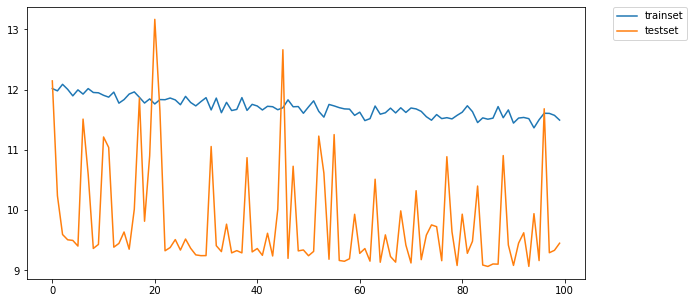

In [198]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [0]:
yhat = model.predict(generator_hold, verbose=2)

In [200]:
yhat.shape

(49, 1)

In [0]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': y[0][0], 'Prediction': yhat[0][0]}, ignore_index=True)

In [203]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_rf = sqrt(mean_squared_error(df_result.Actual, df_result.Prediction))
MAPE= np.mean(np.abs((df_result.Actual - df_result.Prediction) / df_result.Actual)) * 100
print("MAPE: ",MAPE)
print("MAE: ", mean_absolute_error(df_result.Actual, df_result.Prediction))
print("RMSE: ",rmse_rf)

MAPE:  9.269390800643414
MAE:  411.1335249920281
RMSE:  511.44616222137176
ERROR! Session/line number was not unique in database. History logging moved to new session 61
